# Многомерные фильтры Калмана

Фильтрация нескольких СВ

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

## Введение

Изучим полную многомерную форму фильтра Калмана.  Ограничимся подмножеством задач, которые мы можем описать с помощью уравнений движения Ньютона. Эти фильтры называются *дискретизированными непрерывными кинематическими фильтрами*.

## Уравнения движения Ньютона

Уравнения движения Ньютона говорят нам, что при постоянной скорости системы $v$ мы можем вычислить ее положение $x$ через время $t$ с помощью:

$$x = vt + x_0$$

Добавим ускорение в уравнение

$$x = \frac{1}{2}at^2 + v_0t + x_0$$

И если мы предположим, что постоянный рывок, мы получим

$$x = \frac{1}{6}jt^3 +  \frac{1}{2}a_0 t^2 + v_0 t + x_0$$
Эти уравнения были получены путем интегрирования дифференциального уравнения. При постоянной скорости v мы можем вычислить пройденное расстояние во времени с помощью уравнения

$$x = vt + x_0$$


$$\begin{aligned} v &= \frac{dx}{dt}\\
dx &= v\, dt \\
\int_{x_0}^x\, dx &= \int_0^t v\, dt\\
x - x_0 &= vt - 0\\
x &= vt + x_0\end{aligned}$$

При проектировании фильтра Калмана вы начинаете с системы дифференциальных уравнений, описывающих динамику системы. Большинство систем дифференциальных уравнений не интегрируются таким образом. Мы начинаем с уравнения Ньютона, потому что мы можем интегрировать и получить решение в закрытой форме, что упрощает разработку фильтра Калмана. Дополнительным преимуществом является то, что уравнения Ньютона являются правильными уравнениями для отслеживания движущихся объектов, что является одним из основных применений фильтров Калмана.

## Алгоритм фильтра Калмана


**Инициализация**

1. Инициализируйте состояние фильтра
2. Инициализируйте начальные условия(распределения, коорреляции)

**Прогнозировать**

1. Используйте модель динамики процесса для прогнозирования состояния на следующем временном шаге
2. Скорректируйте вывод модели, чтобы учесть неопределенность в прогнозе

**Обновление**

1. Получите измерение и связанную с ним неопределнность
2. Вычислите остаток между оценкой и измерением
3. Вычислите коэффициент масштабирования на основе того, соответствует ли измерение или прогноз более точен
4. Установите состояние между прогнозом и измерением на основе коэффициента масштабирования
5. Обновите параметры распределения

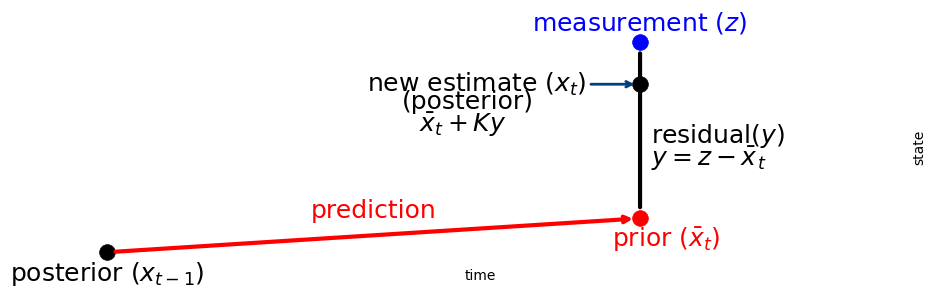

In [41]:
import kf_book.book_plots as book_plots
book_plots.show_residual_chart()

Многомерные гауссианы используют вектор для среднего и матрицу для ковариаций. Это означает, что фильтр Калмана должен использовать линейную алгебру для выполнения оценок.


<u>**Прогноз**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
\bar \mu = \mu + \mu_{f_x} & \bar x = x + dx & \bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar\sigma^2 = \sigma_x^2 + \sigma_{f_x}^2 & \bar P = P + Q & \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\
\hline
\end{array}$



$\mathbf x,\, \mathbf P$ являются средним состоянием и ковариацией. Они соответствуют $x$ и $\sigma^2$.

$\mathbf F$ является *функцией перехода состояния*. При умножении на $\bf x$ он вычисляет предыдущее состояние. 

$\mathbf Q$ отображает наличие ковариаций в процессе. Это соответствует $\sigma^2_{f_x}$.

$\mathbf B$ и $\mathbf u$ являются новыми для нас. Они позволяют нам моделировать управляющие входы в систему.

<u>**Обновление состояния**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
& y = z - \bar x & \mathbf y = \mathbf z - \mathbf{H\bar x} \\
& K = \frac{\bar P}{\bar P+R}&
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2} & x = \bar x + Ky & \mathbf x = \bar{\mathbf x} + \mathbf{Ky} \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} & P = (1-K)\bar P &
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$

$\mathbf H$ является функцией измерения. Если убрать $\mathbf H$ из уравнений, вы должны увидеть, что эти уравнения также похожи.

$\mathbf z,\, \mathbf R$ среднее значение измерений и ковариация шума. Они соотвествуют $z$ и $\sigma_z^2$ в одномерном фильтре (Я заменил $\mu$ на $x$ для одномерных уравнений, чтобы сделать обозначения максимально похожими).

$\mathbf y$ и $\mathbf K$ остатки и коэфициент масштабирования. 

Детали будут отличаться от одномерного фильтра, потому что это векторы и матрицы, но концепции точно такие же:

- Используйте гауссовский процесс, чтобы представить нашу оценку состояния и ошибки
- Используйте гауссовский процесс для представления измерения и его погрешности
- Используйте гауссовскую модель для представления модели процесса
- Используйте модель динамики процесса для прогнозирования следующего состояния (предыдущего)
- Сформируйте оценку в промежуточной точке между измерением и предыдущим

Ваша работа будет заключаться в задании начального состояния $\left(\mathbf x, \mathbf P\right)$, модели процесса $\left(\mathbf F, \mathbf Q\right)$, измерениях  $\left(\mathbf z, \mathbf R\right)$, и функции измерений $\mathbf H$. Если это система имеет обратную связь по контролю то тогда задаются $\mathbf B$ и $\mathbf u$.

## Примеры

Функция будет выполняться для "подсчета" шагов, перемещая объект вперед примерно на 1 метр за каждый шаг. На каждом шаге скорость будет меняться в зависимости от дисперсии процесса "process_var". После обновления положения мы вычисляем измерение с предполагаемой дисперсией датчика "z_var`

In [3]:
import math
import numpy as np
from numpy.random import randn

def compute_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)

## Этап прогноза

Для прогнозирования необходимо спроектировать состояние и ковариацию, модель процесса и шум процесса, а также, возможно, управляющий вход. Рассмотрим их по порядку.

### Начальное состояние

Ранее мы отслеживали объект в одном измерении с помощью ГР. Среднее значение $(\mu)$ представляло наиболее вероятную позицию, а дисперсия ($\sigma^2$) представляла распределение вероятностей позиции. Позиция - это *состояние* системы, и мы называем $\mu$ переменной *состояния*.

В этой задаче мы будем отслеживать как положение, так и скорость. Это требует от нас использования многомерного ГР, представленного вектором состояния $\mathbf x$ и соответствующей ему ковариационной матрицей $\mathbf P$.

Переменные состояния могут быть либо *наблюдаемыми переменными* - непосредственно измеряемыми датчиком, либо *скрытыми переменными* - выводимыми из наблюдаемых переменных. Для нашей проблемы с отслеживанием датчик считывает только положение, поэтому положение наблюдается, а скорость скрыта. 

Важно понимать, что отслеживание положения и скорости - это наш выбор с последствиями и предположениями, которые мы еще не готовы исследовать. Например, мы могли бы также отслеживать ускорение или даже рывок. Однако помним, что включение скорости в ковариационную матрицу привело к гораздо меньшим отклонениям в положении. 

$$\mu = \begin{bmatrix}10.0\\4.5\end{bmatrix}$$

Фильтр Калмана реализован с использованием линейной алгебры. Мы используем матрицу $n\times 1$ (называемую *вектором*) для хранения переменных состояния $n$. Для задачи отслеживания мы используем $x$ для обозначения положения и первую производную от $x$, $\dot x$, для скорости. $\dot x$ представляет первую производную от x по отношению к t: $\dot x = \frac{dx}{dt}$. Уравнения фильтра Калмана используют $\mathbf x$ для состояния, поэтому мы определяем $\mathbf x$ как

$$\mathbf x =\begin{bmatrix}x \\ \dot x\end{bmatrix}$$

Мы используем $\mathbf x$ вместо $\mu$, это среднее значение многомерного гауссова.

Другой способ записать это $\mathbf x=\begin{bmatrix}x &\dot x\end{bmatrix}^\mathbf T$.

$\mathbf x$ и позиция $x$ имеют одно и то же имя. Если бы мы отслеживали по оси y, мы бы написали $\mathbf x=\begin{bmatrix}y &\dot y\end{bmatrix}^\mathsf T$, а не $\mathbf y=\begin{bmatrix}y &\dot y\end{bmatrix}^\mathsf T$. $\mathbf x$ - это стандартное имя переменной состояния, используемое в литературе по фильтру Калмана. 

In [4]:
x = np.array([[10.0],
              [4.5]])
x

array([[10. ],
       [ 4.5]])

In [5]:
x = np.array([[10., 4.5]]).T
x

array([[10. ],
       [ 4.5]])

In [6]:
x = np.array([10.0, 4.5])
x

array([10. ,  4.5])

In [8]:
np.array([1., 0, 0, 0, 0, 0])

array([1., 0., 0., 0., 0., 0.])

In [9]:
A = np.array([[1, 2], [3, 4]])
x = np.array([[10.0], [4.5]])

# matrix multiply
print(np.dot(A, x))
print()

[[19.]
 [48.]]



In [10]:
# alternative matrix multiply)
print(A @ x)
print()

x = np.array([[10.0, 4.5]]).T
print(A @ x)
print()

x = np.array([10.0, 4.5])
print(A @ x)

[[19.]
 [48.]]

[[19.]
 [48.]]

[19. 48.]


### Задаем матрицу ковариаций

Мы указываем начальное значение для $\mathbf P$, и фильтр обновляет его в течение каждой эпохи.

Нам нужно установить отклонения на разумные значения. Например, мы можем выбрать $\sigma_\mathtt{pos}^2=500 m^2$, если мы совершенно не уверены в начальной позиции. Максимальная скорость допустим составляет около 21 м/с, поэтому в отсутствие какой-либо другой информации о скорости мы можем установить $3\sigma_\mathtt{vel}=21$ или $\sigma_\mathtt{vel}^2=7^2=49$.

Связь и ковариации фильтр вычисляет это для нас, поэтому я инициализирую ковариации до нуля. Конечно, если мы знаем ковариации, мы должны их использовать.

Диагонали ковариационной матрицы содержат дисперсию каждой переменной, а недиагональные элементы содержат ковариации. Таким образом, мы имеем:

$$
\mathbf P = \begin{bmatrix}500 & 0 \\ 0&49\end{bmatrix}
$$


In [7]:
P = np.diag([500., 49.])
P

array([[500.,   0.],
       [  0.,  49.]])

In [8]:
P = np.array([[500., 0.],
              [0., 49.]])
P

array([[500.,   0.],
       [  0.,  49.]])

### Модель динамики процесса

Это математическая модель, которая описывает поведение системы. Фильтр использует его для прогнозирования состояния после дискретного временного шага. Мы делаем это с помощью набора уравнений, описывающих динамику системы.

$$ x = v \Delta t + x_0$$

Для одномерного процесса

```python
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, 
                    pos.var + movement.var)
```

Для многомерного процесса

$$ \mathbf x = \begin{bmatrix}5.4\\4.2\end{bmatrix}, \, \, 
\dot{\mathbf x} =  \begin{bmatrix}1.1\\0.\end{bmatrix} \\
\mathbf x = \dot{\mathbf x}t + \mathbf x$$

Но нам нужно обобщить это. Уравнения фильтра Калмана работают с любой линейной системой, а не только с ньютоновскими. Возможно, система, которую вы фильтруете, является водопроводной системой на химическом заводе, и поток в данной трубе определяется линейной комбинацией настроек различных клапанов.

$$\mathtt{pipe_1} = 0.134(\mathtt{valve}_1) + 0.41(\mathtt{valve}_2 - \mathtt{valve}_3) + 1.34$$
$$\mathtt{pipe_2} = 0.210(\mathtt{valve}_2) - 0.62(\mathtt{valve}_1 - \mathtt{valve}_5) + 1.86$$

Линейная алгебра нам в помощь.

$$\begin{cases}
2x+3y=8\\4x-y=2
\end{cases}$$

Перепишем в матричной форме

$$\begin{bmatrix}2& 3 \\ 4&-1\end{bmatrix} \begin{bmatrix}x\\y\end{bmatrix} = \begin{bmatrix}8\\2\end{bmatrix}$$

$\mathbf{Ax}=\mathbf B$, где

$$\mathbf{A} = \begin{bmatrix}2& 3 \\ 4&-1\end{bmatrix},\, \mathbf x = \begin{bmatrix}x\\y\end{bmatrix}, \mathbf B=\begin{bmatrix}8\\2\end{bmatrix}$$


In [9]:
from scipy.linalg import solve
A = np.array([[2, 3],[4, -1]])
b = np.array([[8], [2]])
x = solve(A, b)
x

array([[1.],
       [2.]])

Фильтры Калмана реализуют модель процесса с помощью этого линейного уравнения, где $\mathbf{\bar x}$ - это *предыдущее* или предсказанное состояние:

$$\mathbf{\bar x} = \mathbf{Fx}$$


$$\begin{bmatrix} \bar x \\ \dot{\bar x}\end{bmatrix} = \begin{bmatrix}? & ? \\? & ?\end{bmatrix}\begin{bmatrix}x\\\dot x\end{bmatrix}$$

Наша задача состоит в том, чтобы указать $\mathbf F$ таким образом, чтобы $\bar{\mathbf x}=\mathbf{Fx}$ выполнял прогнозирование для нашей системы. Для этого нам нужно одно уравнение для каждой переменной состояния. В нашей задаче $\mathbf x=\begin{bmatrix}x &\dot x\end{bmatrix}^\mathtt{T}$, поэтому нам нужно одно уравнение для вычисления положения $x$, а другое для вычисления скорости $\dot x$. Мы уже знаем уравнение для позиции:

$$\bar x = x + \dot x \Delta t$$

Каково наше уравнение для скорости? У нас нет прогностической модели того, как скорость будет меняться с течением времени. В этом случае мы предполагаем, что она остается постоянной между прогнозами. Конечно, это не совсем так, но до тех пор, пока скорость не будет слишком сильно меняться с каждым нововведением, вы увидите, что фильтр работает очень хорошо. 

$$\bar{\dot x} = \dot x$$

Это дает нам модель процесса для нашей системы

$$\begin{cases}
\begin{aligned}
\bar x &= x + \dot x \Delta t \\
\bar{\dot x} &= \dot x
\end{aligned}
\end{cases}$$

Нам нужно выразить этот набор уравнений в виде $\bar{\mathbf x} =\mathbf{Fx}$. 

$$\begin{cases}
\begin{aligned}
\bar x &= 1x + &\Delta t\, \dot x \\
\bar{\dot x} &=0x + &1\, \dot x
\end{aligned}
\end{cases}$$


$$\begin{aligned}
\begin{bmatrix}\bar x \\ \bar{\dot x}\end{bmatrix} &= \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix}  \begin{bmatrix}x \\ \dot x\end{bmatrix}\\
\mathbf{\bar x} &= \mathbf{Fx}
\end{aligned}$$

$\mathbf F$ называется *функцией перехода состояния* или *матрицей перехода состояния*.

In [45]:
dt = 0.1
F = np.array([[1, dt],
              [0, 1]])
F

array([[1. , 0.1],
       [0. , 1. ]])

Мы установили положение на 10,0, а скорость - на 4,5 метра в секунду. Мы определили "dt = 0,1", что означает, что временной шаг составляет 0,1 секунды, поэтому мы ожидаем, что новая позиция составит 10,45 метра после нововведения. Скорость должна быть неизменной.

In [47]:
from filterpy.kalman import predict

x = np.array([10.0, 4.5])
P = np.diag([500, 49])
F = np.array([[1, dt], [0, 1]])

# Q is the process noise
x, P = predict(x=x, P=P, F=F, Q=0)
print('x =', x)

x = [10.45  4.5 ]


In [48]:
for _ in range(4):
    x, P = predict(x=x, P=P, F=F, Q=0)
    print('x =', x)

x = [10.9  4.5]
x = [11.35  4.5 ]
x = [11.8  4.5]
x = [12.25  4.5 ]


Значение $\mathbf P$ после пяти предсказаний, которое мы обозначаем $\mathbf{\bar P}$ в уравнениях фильтра Калмана.

In [49]:
print(P)

[[512.25  24.5 ]
 [ 24.5   49.  ]]


Проверка диагоналей показывает нам, что дисперсия положения стала больше. Мы выполнили пять этапов прогнозирования без каких-либо измерений, и наша неопределенность возросла. Недиагональные элементы стали ненулевыми - фильтр Калмана обнаружил корреляцию между положением и скоростью. Отклонение скорости не изменилось.

Здесь я строю ковариацию до и после предсказания. Начальное значение выделено сплошным красным цветом, а предыдущее (прогноз) - черным пунктиром. Я изменил ковариацию и временной шаг, чтобы лучше проиллюстрировать это изменение.

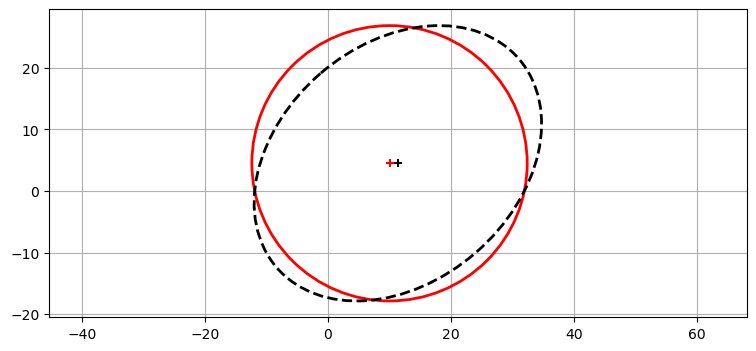

In [50]:
from filterpy.stats import plot_covariance_ellipse

dt = 0.3
F = np.array([[1, dt], [0, 1]])
x = np.array([10.0, 4.5])
P = np.diag([500, 500])
plot_covariance_ellipse(x, P, edgecolor='r')
x, P = predict(x, P, F, Q=0)
plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')

Вы можете видеть, что центр эллипса сместился на небольшую величину (с 10 до 11,35), потому что положение изменилось. Эллипс также вытянулся, показывая корреляцию между положением и скоростью. Как фильтр вычисляет новые значения для $\mathbf{\bar P}$ и на чем он основан? Обратите внимание, что я каждый раз устанавливаю шум процесса "Q" равным нулю, поэтому это не связано с добавлением шума.

### Модель шума процесса

Краткий обзор *шума процесса*. Автомобиль едет по дороге с включенным круиз-контролем; он должен двигаться с постоянной скоростью. Мы моделируем это с помощью $\bar x_k=\dot x_k\delta t+x_{k-1}$. Однако на это влияет ряд неизвестных факторов. Круиз-контроль не может идеально поддерживать постоянную скорость. Ветер влияет на машину, как и холмы и выбоины. Пассажиры опускают стекла, изменяя профиль сопротивления автомобиля.

$$\dot{\mathbf x} = f(\mathbf x) + w$$

где $f(\mathbf x)$моделирует переход состояния, а $w$ - это *белый шум процесса*.

На данный момент вам просто нужно знать, что мы учитываем шум в системе, добавляя матрицу ковариации шума процесса $\mathbf Q$ к ковариации $\mathbf P$. Мы ничего не добавляем к $\mathbf x$, потому что шум *белый*, что означает, что среднее значение шума будет равно 0. Если среднее значение равно 0, $\mathbf x$ не изменится.

Одномерный фильтр Калмана использовал "дисперсию = дисперсию + process_noise" для вычисления дисперсии для дисперсии шага прогнозирования. Многомерный фильтр Калмана делает то же самое, по существу "P = P + Q". 

Вывод матрицы шума процесса может быть довольно сложным. На данный момент известно, что $\mathbf Q$ равно ожидаемому значению белого шума $w$, вычисленному как $\mathbf Q=\mathbb E[\mathbf{ww}^\mathsf T]$. 

"Q_discrete_white_noise" принимает 3 параметра. "dim", который определяет размер матрицы, "dt", который представляет собой временной шаг в секундах, и "var", отклонение в шуме. Вкратце, он дискретизирует шум в течение заданного периода времени в соответствии с предположениями, которые мы обсудим позже. Этот код вычисляет $\mathbf Q$ для белого шума с дисперсией 2,35 и шагом по времени 1 сек.:

In [15]:
from filterpy.common import Q_discrete_white_noise
Q = Q_discrete_white_noise(dim=2, dt=1., var=2.35)
print(Q)

[[0.588 1.175]
 [1.175 2.35 ]]


### Функция контроля

Фильтр Калмана не просто фильтрует данные, он позволяет нам включать управляющие входы таких систем. На каждом временном шаге мы посылали бы сигналы управления и скорости в зависимости от его текущего положения по сравнению с желаемым положением. Уравнения фильтра Калмана включают эти знания в уравнения фильтра, создавая прогнозируемое положение, основанное как на текущей скорости, так и на управляющих входах для приводных двигателей.

Для линейной системы влияние управляющих входов может быть описано как набор линейных уравнений, которые мы можем выразить с помощью линейной алгебры как

$$\Delta\mathbf x=\mathbf{Bu}$$

Здесь $\mathbf u$ - это *управляющий вход*, а $\mathbf B$ - это *модель управляющего входа* или * функция управления*. Например, $\mathbf u$ может быть напряжением, управляющим скоростью вращения двигателя колеса, и умножение на $\mathbf B$ дает $\Delta[\begin{smallmatrix}x\\dot x\end{smallmatrix}]$. Другими словами, он должен вычислить, сколько $\mathbf x$ изменяется из-за управляющего ввода.

Поэтому полное уравнение фильтра Калмана для предыдущего среднего равно

$$\mathbf{\bar x}= \mathbf{Fx}+ \mathbf{Bu}$$


In [16]:
B = 0. 
u = 0
x, P = predict(x, P, F, Q, B, u)
print('x =', x)
print('P =', P)

x = [12.7  4.5]
P = [[680.587 301.175]
 [301.175 502.35 ]]


In [17]:
predict(x, P, F, Q)[0] == predict(x, P, F, Q, B, u)[0]

array([ True,  True])

In [18]:
predict(x, P, F, Q)[1] == predict(x, P, F, Q, B, u)[1]

array([[ True,  True],
       [ True,  True]])


#### Prediction: Summary


* $\mathbf x$, $\mathbf P$: начальное состояние и матрица ковариаций
* $\mathbf F$,  $\mathbf Q$: модель динамики процесса и модель шума
* $\mathbf{B,u}$: Контроль

## Шаг обновления

Теперь мы можем реализовать этап обновления фильтра. Вам нужно всего лишь предоставить еще две матрицы, и их легко понять.

### Разработайте функцию измерения

Фильтр Калмана вычисляет шаг обновления в том, что мы называем "пространством измерений". Мы отслеживали местоположение с помощью датчика, который сообщал о ее местоположении. Вычисление *остатка* было простым - вычтите прогнозируемое положение фильтра из измерения:

$$ \mathtt{residual} = \mathtt{measured\, \, position} - \mathtt{predicted\, \, position}$$

Нам нужно вычислить остаток, потому что мы масштабируем его по коэффициенту Калмана, чтобы получить новую оценку.

Что бы произошло, если бы мы пытались отслеживать температуру с помощью термометра, который выдает напряжение, соответствующее показаниям температуры? Уравнение для вычисления остатка было бы бессмысленным; вы не можете вычесть температуру из напряжения.

$$ \mathtt{residual} = \mathtt{voltage} - \mathtt{temperature}\;\;\;(NONSENSE!)$$


Нам нужно преобразовать температуру в напряжение, чтобы мы могли выполнить вычитание:

```python
CELSIUS_TO_VOLTS = 0.21475
residual = voltage - (CELSIUS_TO_VOLTS * predicted_temperature)
```

Фильтр Калмана обобщает эту проблему, предоставляя вам функцию измерения, которая преобразует состояние в измерение.

Почему мы работаем в пространстве измерений? Почему бы не работать в пространстве состояний, преобразуя напряжение в температуру, позволяя остаточному значению быть разницей в температуре?

Мы не можем этого сделать, потому что большинство измерений не являются *обратимыми*. Состояние проблемы отслеживания содержит скрытую переменную $\dot x$. Нет способа преобразовать измерение положения в состояние, содержащее скорость. С другой стороны, тривиально преобразовать состояние, содержащее положение и скорость, в эквивалентное "измерение", содержащее только положение. Мы должны работать в измерительном пространстве, чтобы сделать возможным вычисление остатка.

Как измерение $\mathbf z$, так и состояние $\mathbf x$ являются векторами, поэтому нам нужно использовать матрицу для выполнения преобразования. Уравнение фильтра Калмана, которое выполняет этот шаг, является:

$$\mathbf y=\mathbf z-\mathbf{H\bar x}$$

где $\mathbf y$ - остаток, $\mathbf{\bar x}$ - предшествующее состояние, $\mathbf z$ - измерение, а $\mathbf H$ - функция измерения. Итак, мы берем предыдущее, преобразуем его в измерение, умножив его на $\mathbf H$, и вычитаем это из измерения. Это дает нам разницу между нашим предсказанием и измерением в пространстве измерений!
<img src="./figs/residual_chart_with_h.png">

Нам нужно спроектировать $\mathbf H$ так, чтобы $\mathbf{H\bar x}$ давал измерение. Для этой задачи у нас есть датчик, который измеряет положение, поэтому $\mathbf z$ будет вектором с одной переменной:

$$\mathbf z = \begin{bmatrix}z\end{bmatrix}$$

Уравнение остатков будет иметь вид

$$
\begin{aligned}
\textbf{y} &= \mathbf z - \mathbf{H\bar x}  \\
\begin{bmatrix}y \end{bmatrix} &= \begin{bmatrix}z\end{bmatrix} - \begin{bmatrix}?&?\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix}
\end{aligned}
$$

$\mathbf H$ должна быть матрица 1x2 для $\mathbf{Hx}$ быть 1х1.

Мы захотим умножить позицию $x$ на 1, чтобы получить соответствующее измерение позиции. Нам не нужно использовать скорость, чтобы найти соответствующее измерение, поэтому мы умножаем $\dot x$ на 0.

$$\begin{aligned}
\textbf{y} &= \mathbf z - \begin{bmatrix}1&0\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix} \\
&= [z] - [x]
\end{aligned}$$

Итак, для нашего фильтра Калмана мы установили
$$\mathbf H=\begin{bmatrix}1&0\end{bmatrix}$$

In [19]:
H = np.array([[1., 0.]])

Мы разработали большую часть нашего фильтра Калмана. Все, что осталось, - это смоделировать шум в датчиках.

####  Начальное состояние

Измерение реализуется с помощью $\mathbf z$, среднего значения измерения, и $\mathbf R$, ковариации измерения.

$\mathbf z$ он содержит измерение(измерения) в виде вектора. У нас есть только одно измерение, поэтому у нас есть:

$$\mathbf z = \begin{bmatrix}z\end{bmatrix}$$


$$\mathbf z = \begin{bmatrix}z_1 \\ z_2\end{bmatrix}$$

*Матрица шума измерения* моделирует шум в наших датчиках в виде ковариационной матрицы. На практике это может быть непросто. В сложной системе может быть много датчиков, корреляция между ними может быть неясной, и обычно их шум не является чистым гауссовым. Например, датчик может быть смещен для считывания высоких значений, если температура высокая, и поэтому шум не распределяется равномерно по обе стороны от среднего значения.

Уравнения фильтра Калмана используют ковариационную матрицу $\mathbf R$ для шума измерения. Матрица будет иметь размерность $m{\times}m$, где $m$ - количество датчиков. Это ковариационная матрица для учета корреляций между датчиками. У нас есть только 1 датчик или есть:

$$R = \begin{bmatrix}\sigma^2_z\end{bmatrix}$$

Если $\sigma^2_z$ равно 5 квадратным метрам, у нас будет $R= \begin{bmatrix}5\end{bmatrix}$.

Если бы у нас было два датчика положения, первый с отклонением 5 m$^2$, второй с отклонением 3 m$^2$, мы бы написали

$$R = \begin{bmatrix}5&0\\0&3\end{bmatrix}$$

Мы помещаем отклонения по диагонали, потому что это матрица *ковариации*, где отклонения лежат по диагонали, а ковариации, если таковые имеются, лежат в недиагональных элементах. Здесь мы предполагаем, что между двумя датчиками нет корреляции в шуме, поэтому ковариации равны 0.

Для нашей проблемы у нас есть только один датчик, поэтому мы можем реализовать это как

In [20]:
R = np.array([[5.]])

In [21]:
from filterpy.kalman import update
z = 1.
x, P = update(x, P, z, R, H)
print('x =', x)

x = [ 1.085 -0.64 ]


## Реализация фильтра Калмана


In [28]:
from filterpy.kalman import KalmanFilter
obj_filter = KalmanFilter(dim_x=2, dim_z=1)
print('x = ', obj_filter.x.T)
print('R = ', obj_filter.R)
print('Q = \n', obj_filter.Q)

x =  [[0. 0.]]
R =  [[1.]]
Q = 
 [[1. 0.]
 [0. 1.]]


Теперь мы инициализируем матрицы и векторы фильтра значениями, допустимыми для нашей задачи. Я поместил это в функцию, чтобы вы могли указать различные начальные значения для "R", "P" и "Q" и поместить их во вспомогательную функцию.

In [29]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = np.array([[1., dt],
                     [0.,  1.]])  # state transition matrix
    kf.H = np.array([[1., 0]])    # Measurement function
    kf.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q[:] = Q
    return kf

"Фильтр Калмана" инициализирует "R", "P" и "Q" в матрицу идентификаторов, поэтому "kf.P*= P" - это один из способов быстро присвоить всем диагональным элементам одно и то же скалярное значение. Теперь мы создаем фильтр:

In [30]:
dt = .1
x = np.array([0., 0.]) 
kf = pos_vel_filter(x, P=500, R=5, Q=0.1, dt=dt)

In [31]:
kf

KalmanFilter object
dim_x = 2
dim_z = 1
dim_u = 0
x = [0. 0.]
P = [[500.   0.]
     [  0. 500.]]
x_prior = [[0. 0.]].T
P_prior = [[1. 0.]
           [0. 1.]]
x_post = [[0. 0.]].T
P_post = [[1. 0.]
          [0. 1.]]
F = [[1.  0.1]
     [0.  1. ]]
Q = [[0.    0.   ]
     [0.    0.001]]
R = [[5.]]
H = [[1. 0.]]
K = [[0. 0.]].T
y = [[0.]]
S = [[0.]]
SI = [[0.]]
M = [[0.]]
B = None
z = [[None]]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
alpha = 1.0
inv = <function inv at 0x0000017E4EDF9D30>

In [34]:
from kf_book.mkf_internal import plot_track

def run(x0=(0.,0.), P=500, R=0, Q=0, dt=1.0, 
        track=None, zs=None,
        count=0, do_plot=True, **kwargs):
    """
    track is the actual position of the dog, zs are the 
    corresponding measurements. 
    """

    # Simulate dog if no data provided. 
    if zs is None:
        track, zs = compute_data(R, Q, count)

    # create the Kalman filter
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)  

    # run the kalman filter and store the results
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    xs, cov = np.array(xs), np.array(cov)
    if do_plot:
        plot_track(xs[:, 0], track, zs, cov, **kwargs)
    return xs, cov

У нас есть 50 измерений с дисперсией шума 10 и дисперсией процесса 0,01.

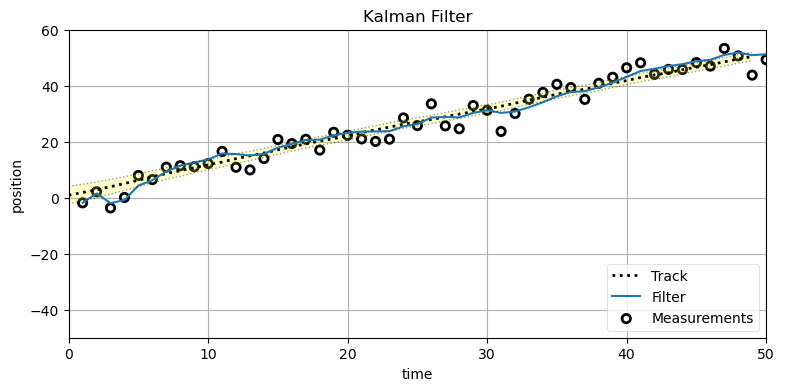

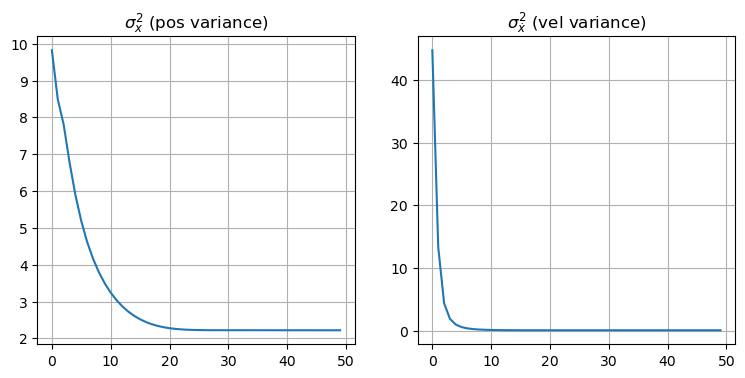

In [35]:
P = np.diag([500., 49.])
Ms, Ps = run(count=50, R=10, Q=0.01, P=P)

На первом графике вывод фильтра Калмана сопоставляется с измерениями и фактическим положением. После первоначального периода. Желтая заштрихованная часть между черными пунктирными линиями показывает 1 стандартное отклонение дисперсии фильтра.

Следующие два графика показывают дисперсию $x$ и $\dot x$. Я построил диагонали $\mathbf P$ с течением времени. Напомним, что диагональ ковариационной матрицы содержит дисперсию каждой переменной состояния. Таким образом, $\mathbf P[0,0]$ - это дисперсия $x$, а $\mathbf P[1,1]$ - это дисперсия $\dot x$. Вы можете видеть, что мы быстро сходимся к небольшим отклонениям для обоих.

Ковариационная матрица $\mathbf P$ сообщает нам *теоретическую* производительность фильтра *при условии, что* все, что мы говорим, является правдой. Напомним, что стандартное отклонение - это квадратный корень из дисперсии, и что примерно 68 % распределения по Гауссу происходит в пределах одного стандартного отклонения. Если по крайней мере 68 % выходного сигнала фильтра находится в пределах одного стандартного отклонения, фильтр может работать хорошо. На верхней диаграмме я отобразил одно стандартное отклонение в виде желтой заштрихованной области между двумя пунктирными линиями. На мой взгляд, похоже, что, возможно, фильтр немного превышает эти границы, поэтому фильтр, вероятно, нуждается в некоторой настройке.

В одномерной главе мы фильтровали очень шумные сигналы с помощью гораздо более простого кода, чем приведенный выше. Однако поймите, что сейчас мы работаем с очень простым примером - объектом, движущимся в одномерном пространстве, и одним датчиком. Это примерно предел того, что мы можем вычислить с помощью кода в предыдущей главе. Напротив, мы можем реализовать очень сложные многомерные фильтры с помощью этого кода, просто изменив наши назначения переменным фильтра. Возможно, мы хотим отслеживать 100 измерений в финансовых моделях. Или у нас есть самолет с GPS, INS, TACAN, радиолокационным высотомером, баровысотомером и индикатором воздушной скорости, и мы хотим интегрировать все эти датчики в модель, которая предсказывает положение, скорость и ускорение в трехмерном пространстве. 

3D-график, показывающий ГР каждую 7-ю эпоху (временной шаг). Каждый 7-й отделяет их достаточно, чтобы видеть каждого из них независимо. Первый ГР при $t=0$ находится слева.

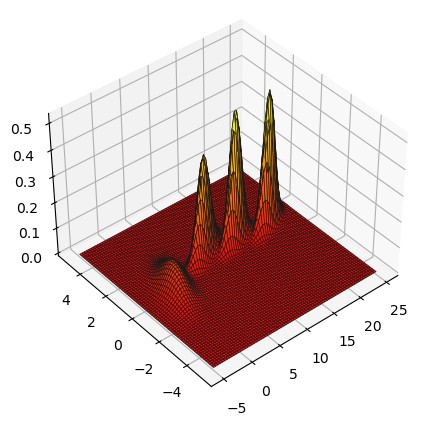

In [36]:
from kf_book.book_plots import set_figsize, figsize
from kf_book.nonlinear_plots import plot_gaussians

P = np.diag([3., 1.])
np.random.seed(3)
Ms, Ps = run(count=25, R=10, Q=0.01, P=P, do_plot=False)
with figsize(x=9, y=5):
    plot_gaussians(Ms[::7], Ps[::7], (-5,25), (-5, 5), 75)

In [37]:
from filterpy.common import Saver
kf = pos_vel_filter([0, .1], R=R, P=P, Q=Q, dt=1.) 
s = Saver(kf)
for i in range(1, 6):
    kf.predict()
    kf.update([i])
    s.save()  # save the current state

Объект "Saver" теперь содержит списки всех атрибутов объекта фильтра Калмана. "kf.x" - это оценка текущего состояния фильтра. Поэтому "s.x" содержит оценку сохраненного состояния, которая была вычислена внутри цикла:

In [38]:
s.x

[array([0.357, 0.165]),
 array([1.03 , 0.326]),
 array([1.996, 0.513]),
 array([3.109, 0.665]),
 array([4.255, 0.771])]

In [39]:
s.keys

['alpha',
 'likelihood',
 'log_likelihood',
 'mahalanobis',
 'dim_x',
 'dim_z',
 'dim_u',
 'x',
 'P',
 'Q',
 'B',
 'F',
 'H',
 'R',
 '_alpha_sq',
 'M',
 'z',
 'K',
 'y',
 'S',
 'SI',
 '_I',
 'x_prior',
 'P_prior',
 'x_post',
 'P_post',
 '_log_likelihood',
 '_likelihood',
 '_mahalanobis',
 'inv']

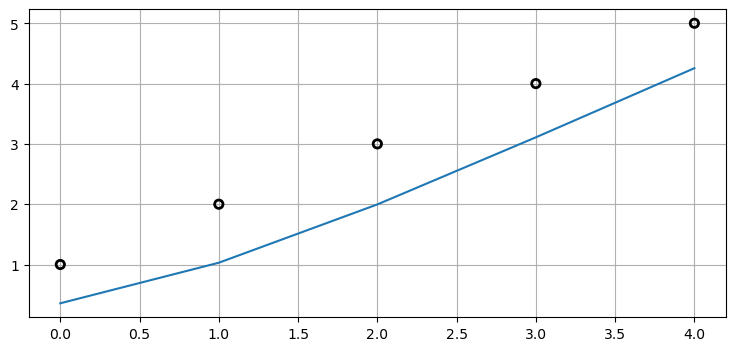

In [42]:
import matplotlib.pyplot as plt

s.to_array()
book_plots.plot_measurements(s.z);
plt.plot(s.x[:, 0]);

## Уравнения фильтра Калмана


### Уравнения прогнозирования

Фильтр Калмана использует эти уравнения для вычисления *предыдущего* - предсказанного следующего состояния системы. Они вычисляют предыдущее среднее значение ($\bar{\mathbf x}$) и ковариацию ($\bar{\mathbf P}$) системы.

$$\begin{aligned}
\mathbf{\bar x} &= \mathbf{Fx} + \mathbf{Bu}\\
\mathbf{\bar P} &= \mathbf{FPF}^\mathsf T + \mathbf Q
\end{aligned}$$

$\underline{\textbf{Mean}}$

$\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$

Напомним, что линейное уравнение $\mathbf{Ax} = \mathbf b$ представляет собой систему уравнений, где $\mathbf A$ содержит набор коэффициентов уравнений, $\mathbf x$ - вектор переменных. Выполнение умножения $\mathbf{Ax}$ вычисляет значения правой части для этого набора уравнений, представленных $\mathbf b$.

Если $\mathbf F$ содержит переход состояния для заданного временного шага, то произведение $\mathbf{Fx}$ вычисляет состояние после этого перехода. Аналогично, $\mathbf B$ является функцией управления, $\mathbf u$ является управляющим входом, поэтому $\mathbf{Bu}$ вычисляет вклад элементов управления в состояние после перехода. Таким образом, $\mathbf{\bar x}$ вычисляется как сумма $\mathbf{Fx}$ и $\mathbf{Bu}$.

Эквивалентное одномерное уравнение имеет вид

$$\bar\mu = \mu + \mu_{move}$$

Если вы выполните умножение матрицы $\mathbf{Fx}$, оно сгенерирует это уравнение для $x$.

Давайте проясним это. Вспомните значение для $\mathbf F$ из предыдущей главы:

$$\mathbf F=\begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}$$

Таким образом, $\mathbf{\bar x}= \mathbf{Fx}$ соответствует набору линейных уравнений:

$$\begin{cases}
\begin{aligned}
\bar x &= 1x + &\Delta t\, \dot x \\
\bar{\dot x} &=0x + &1\, \dot x
\end{aligned}
\end{cases}$$

$\underline{\textbf{Covariance}}$

$\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q$

Это уравнение не так просто понять, поэтому мы потратим на него больше времени.

В одномерной версии этого уравнения:

$$\bar\sigma^2 = \sigma^2 + \sigma^2_{move}$$

Мы добавляем отклонение движения к отклонению нашей оценки, чтобы отразить потерю знаний. Нам нужно сделать то же самое здесь, за исключением того, что это не так просто с многомерными гауссианами.

Мы не можем просто написать $\mathbf{\bar P} = \mathbf P + \mathbf Q$. В многомерном гауссовом уравнении переменные состояния *коррелированы*. Что это означает? Наше знание скорости несовершенно, но мы добавляем его к положению с

$$\bar x = \dot x\Delta t + x$$

Поскольку мы не обладаем знанием значения $\dot x$, сумма $\bar x = \dot x\Delta t + x$ приобретает неопределенность. Поскольку положения и скорости коррелированы, мы не можем просто добавить ковариационные матрицы. Например, если $\mathbf P$ и $\mathbf Q$ являются диагональными матрицами, сумма также будет диагональной. Но мы знаем, что положение коррелирует со скоростью, поэтому недиагональные элементы должны быть ненулевыми.

Правильное уравнение таково

$$\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q$$

Выражения в виде $\mathbf{ABA}^\mathsf T$ распространены в линейной алгебре. Вы можете думать об этом как о "проецировании". 

Когда мы инициализируем $\mathbf P$ с помощью

$$\mathbf P = \begin{bmatrix}\sigma^2_x & 0 \\ 0 & \sigma^2_v\end{bmatrix}$$


значение для $\mathbf{FPF}^\mathsf T$ равно:

$$\begin{aligned}
\mathbf{FPF}^\mathsf T &= \begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}
\begin{bmatrix}\sigma^2_x & 0 \\  0 & \sigma^2_{v}\end{bmatrix}
\begin{bmatrix}1&0\\\Delta t&1\end{bmatrix} \\
&= \begin{bmatrix}\sigma^2_x&\sigma_v^2\Delta t\\  0 & \sigma^2_{v}\end{bmatrix}
\begin{bmatrix}1&0\\\Delta t&1\end{bmatrix} \\
&= \begin{bmatrix}\sigma^2_x +  \sigma_v^2\Delta t^2  &  \sigma_v^2\Delta t \\
\sigma_v^2\Delta t & \sigma^2_{v}\end{bmatrix}
\end{aligned}$$

Начальное значение для $\mathbf P$ не имело ковариации между положением и скоростью. Позиция вычисляется как $\dot x\Delta t+ x$, поэтому существует корреляция между положением и скоростью. Умножение $\mathbf{FPF}^\mathsf T$ вычисляет ковариацию $\sigma_v^2\Delta t$. Точное значение не важно; просто нужно признать, что $\mathbf{FPF}^\mathsf T$ использует модель процесса для автоматического вычисления ковариации между положением и скоростью

Другой способ подумать об этом - поразмыслить над умножением $\mathbf{Fx}$. Это предсказывало $\mathbf x$ вперед во времени. $\mathbf {FP}$ может показаться эквивалентной операцией, но $\mathbf P$ - это матрица, а $\mathbf x$ - вектор. $\mathbf F^\mathsf T$ гарантирует, что мы умножим как на строки, так и на столбцы $\mathbf F$. Во второй строке вычисления $\mathbf{FPF}^\mathsf T$ у нас есть значение для $\mathbf{FP}$. Вы можете видеть, что это верхняя треугольная матрица, потому что мы не полностью включили $\mathbf F$ в умножение.

Ковариация, обусловленная предсказанием, может быть смоделирована как ожидаемое значение ошибки на этапе прогнозирования, заданное этим уравнением.

$$\begin{aligned}
\bar{\mathbf P} &= \mathbb E[(\mathbf{Fx - \bar \mu})(\mathbf{Fx - \bar\mu})^\mathsf T]\\
 &= \mathbf F\, \mathbb E[\mathbf{(x- \bar\mu)(x- \bar\mu)}^\mathsf T]\, \mathbf F^\mathsf T
\end{aligned}$$

Конечно, $\mathbb E[\mathbf{(x-\bar\mu)(x-\bar\mu)}^\mathsf T]$ - это просто $\mathbf P$, дающий нам

$$\bar{\mathbf P} = \mathbf{FPF}^\mathsf T$$

Давайте посмотрим на его эффект. Здесь я использую $\mathbf F$ из нашего фильтра и проецирую состояние вперед на 6/10 секунды. Я делаю это пять раз, чтобы вы могли видеть, как $\mathbf{\bar P}$ продолжает меняться.

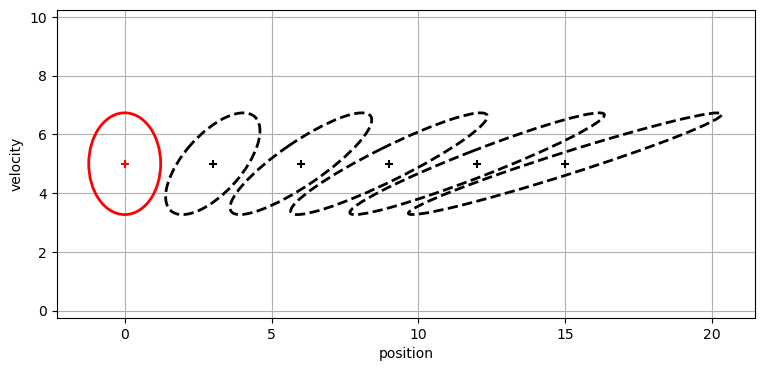

In [43]:
dt = 0.6
x = np.array([0., 5.])
F = np.array([[1., dt], [0, 1.]])
P = np.array([[1.5, 0], [0, 3.]])
plot_covariance_ellipse(x, P, edgecolor='r')

for _ in range(5):
    x = F @ x
    P = F @ P @ F.T
    plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')
book_plots.set_labels(x='position', y='velocity')

https://git.io/vza7b

http://mybinder.org/repo/rlabbe/Kalman-and-Bayesian-Filters-in-Python

Вы можете видеть, что со скоростью 5 позиция правильно перемещается на 3 единицы за каждые 6/10 секунды. На каждом шаге ширина эллипса больше, что указывает на то, что мы потеряли информацию о позиции из-за добавления $\dot x\Delta t$ к x на каждом шаге. Высота не изменилась - наша модель говорит, что скорость не меняется, поэтому наше представление о скорости не может измениться. С течением времени вы можете видеть, что эллипс становится все более и более наклонным. Напомним, что наклон указывает на *корреляцию*. $\mathbf F$ линейно коррелирует $x$ с $\dot x$ с выражением $\bar x = \dot x \Delta t + x$. Вычисление $\mathbf{FPF}^\mathsf T$ правильно включает эту корреляцию в ковариационную матрицу.

Вот анимация этого уравнения, которая позволяет вам изменить $\mathbf F$, чтобы увидеть, как это влияет на форму $\mathbf P$. Ползунок "F00" влияет на значение F[0, 0]. "covar" задает начальную ковариацию между положением и скоростью ($\sigma_x\sigma_{\dot x}$).

* что делать, если $x$ не соотносится с $\dot x$? (установите для F01 значение 0, остальное по умолчанию)
* что, если $x = 2\dot x\Delta t + x_0$? (установите для F01 значение 2, остальное по умолчанию)
* что, если $x = \dot x\Delta t + 2x_0$? (установите значение F00 равным 2, остальное по умолчанию)
* что, если $x = \dot x\Delta t$? (установите значение F00 равным 0, остальное по умолчанию)

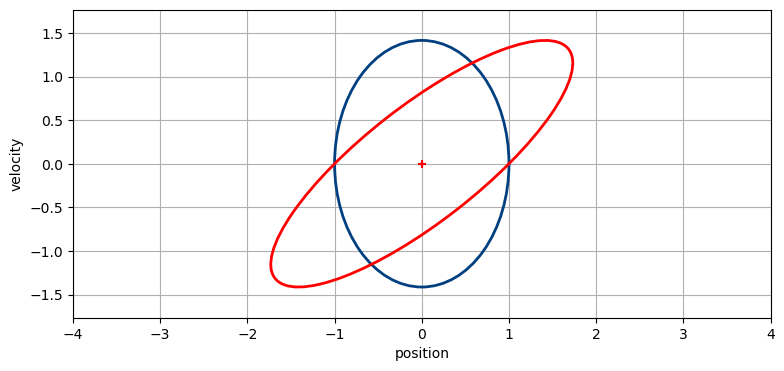

In [44]:
from ipywidgets import interact
from kf_book.book_plots import IntSlider, FloatSlider

def plot_FPFT(F00, F01, F10, F11, covar):   
    plt.figure()
    dt = 1.
    x = np.array((0, 0.))
    P = np.array(((1, covar), (covar, 2)))
    F = np.array(((F00, F01), (F10, F11)))
    plot_covariance_ellipse(x, P)
    plot_covariance_ellipse(x, F @ P @ F.T, ec='r')
    plt.gca().set_aspect('equal')
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    #plt.title(str(F))
    plt.xlabel('position')
    plt.ylabel('velocity')
                 
interact(plot_FPFT, 
         F00=IntSlider(value=1, min=0, max=2), 
         F01=FloatSlider(value=1, min=0, max=2, description='F01(dt)'),
         F10=FloatSlider(value=0, min=0, max=2),
         F11=FloatSlider(value=1, min=0, max=2),
         covar=FloatSlider(value=0, min=0, max=1));

### Обновление системы
Уравнения обновления выглядят более запутанными, чем прогностические уравнения, но это в основном связано с фильтром Калмана, вычисляющим обновление в пространстве измерений. Это происходит потому, что измерения не являются *обратимыми*. Например, рассмотрим датчик, который определяет дальность до цели. Невозможно преобразовать диапазон в позицию - бесконечное количество позиций в круге даст один и тот же диапазон. С другой стороны, мы всегда можем вычислить диапазон (измерение), заданный положением (состоянием).


$\underline{\textbf{System Uncertainty}}$

$\textbf{S} = \mathbf{H\bar PH}^\mathsf Т+ \mathbf Р$

Для работы в пространстве измерений фильтр Калмана должен спроецировать ковариационную матрицу в пространство измерений. $\mathbf{H\bar PH}^\mathsf T$, где $\mathbf{\bar P}$ - это *предшествующая* ковариация, а $\mathbf H$ - функция измерения.


$\mathbf{ABA}^\mathsf T$ - шаг прогнозирования, используемый $\mathbf{FPF}^\mathsf T$ для обновления $\mathbf P$ с функцией перехода состояния. Здесь мы используем ту же форму, чтобы обновить ее с помощью функции измерения. Линейная алгебра меняет для нас систему координат.

Как только ковариация окажется в измерительном пространстве, нам нужно будет учесть шум датчика. Это очень просто - мы просто добавляем матрицы. Результат по-разному называют "системной неопределенностью" или "ковариацией прогнозов".

Если вы игнорируете термин $\mathbf H$, это уравнение эквивалентно знаменателю в одномерном уравнении для коэффициента усиления Калмана:

$$K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2}$$

Сравните уравнения для системной неопределенности и ковариации

$$\begin{aligned}
\mathbf{S} &= \mathbf{H\bar PH}^\mathsf T + \mathbf R\\
\mathbf{\bar P} &= \mathbf{FPF}^\mathsf T + \mathbf Q
\end{aligned}$$


В каждом уравнении $\mathbf P$ помещается в другое пространство либо с функцией $\mathbf H$, либо $\mathbf F$. Затем мы добавляем матрицу шума, связанную с этим пространством.

$\underline{\textbf{Kalman Gain}}$

$\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1}$

Как только у нас есть прогноз и измерение, нам нужно выбрать оценку где-то между ними. Если у нас будет больше уверенности в измерении, оценка будет ближе к нему. Если вместо этого у нас будет больше уверенности в прогнозе, то оценка будет ближе к нему.

В одномерной главе мы масштабировали среднее значение, используя это уравнение

$$
\mu =\frac{\bar\sigma^2 \mu_z + \sigma_\mathtt{z}^2 \bar\mu} {\bar\sigma^2 + \sigma_\mathtt{z}^2}$$

который мы упростили до

$$\mu = (1-K)\bar\mu + K\mu_\mathtt{z}$$
что дало нам

$$K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2}$$

$K$ - это *коэффициент Калмана*, и это реальное число от 0 до 1. Оно выбирает среднее значение где-то между прогнозом и измерением. Коэффициент Калмана равен *проценту* или *соотношению* - если K равно .9, требуется 90 % измерения и 10 % прогноза.

Для многомерного фильтра Калмана $\mathbf K$ является вектором, а не скаляром. Вот снова уравнение: $\mathbf K=\mathbf{\bar PH}^\mathsf T\mathbf{S}^{-1}$. Это *соотношение*? Деление не определено для матриц, но полезно думать об этом таким образом. Таким образом, мы можем прочитать уравнение для $\textbf{K}$ как означающее

$$\begin{aligned} \mathbf K &\approx \frac{\mathbf{\bar P}\mathbf H^\mathsf T}{\mathbf{S}} \\
\mathbf K &\approx \frac{\mathsf{uncertainty}_\mathsf{prediction}}{\mathsf{uncertainty}_\mathsf{prediction} + \mathsf{uncertainty}_\mathsf{measurement}}\mathbf H^\mathsf T
\end{aligned}$$

Уравнение усиления Калмана вычисляет соотношение, основанное на том, насколько мы доверяем прогнозу по сравнению с измерением.  Уравнение сложное, потому что мы делаем это в нескольких измерениях с помощью матриц, но концепция проста. 
$\underline{\textbf{Residual}}$

$\mathbf y = \mathbf z - \mathbf{H\bar{x}}$

Это несложно, так как мы рассмотрели это уравнение при разработке функции измерения $\mathbf H$. Напомним, что функция измерения преобразует состояние в измерение. Таким образом, $\mathbf{Hx}$ преобразует $\mathbf x$ в эквивалентное измерение. Как только это будет сделано, мы можем вычесть его из измерения $\mathbf z$, чтобы получить остаток - разницу между измерением и прогнозом.

Одномерное уравнение имеет вид

$$y =z - \бар x$$

и явно вычисляет то же самое, но только в одном измерении.

$\underline{\textbf{State Update}}$

$\mathbf x = \mathbf{\bar x} + \mathbf{Ky}$

Мы выбираем наше новое состояние по остаточному, масштабируемому коэффициенту Калмана. Масштабирование выполняется с помощью $\mathbf{Ky}$, который одновременно масштабирует остаток и преобразует его обратно в пространство состояний с помощью термина $\mathbf H^\mathsf T$, который находится в $\mathbf K$. Это добавляется к предыдущему, в результате чего получается уравнение: $\mathbf x = \mathbf{\bar x} + \mathbf{Ky}$. Позвольте мне записать $\mathbf K$, чтобы мы могли видеть все вычисления:

$$\begin{aligned}
\mathbf x &= \mathbf{\bar x} + \mathbf{Ky} \\
&= \mathbf{\bar x} + \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1}\mathbf y \\
&\approx \mathbf{\bar x} + \frac{\mathsf{uncertainty}_\mathsf{prediction}}{\mathsf{uncertainty}_\mathsf{measurement}}\mathbf H^\mathsf T\mathbf y
\end{aligned}$$

Возможно, лучший способ *увидеть* соотношение - переписать уравнение оценки:

$$\begin{aligned}
\mathbf x &= \mathbf{\bar x} + \mathbf{Ky} \\
&= \mathbf{\bar x} +\mathbf K(\mathbf z - \mathbf{H\bar x}) \\
&= (\mathbf I - \mathbf{KH})\mathbf{\bar x} + \mathbf{Kz}
\end{aligned}$$


Сходство между этой и одномерной формой должно быть очевидным:
$$\mu = (1-K)\bar\mu + K\mu_\mathtt{z}$$

$\underline{\textbf{Covariance Update}}$

$\mathbf P = (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}$

$\mathbf{I}$ - это матрица идентичности, и это способ представления $1$ в нескольких измерениях. $\mathbf H$ - это наша функция измерения, и она является константой. Мы можем представить уравнение как $\mathbf P = (1-c\mathbf K)\mathbf P$. $\mathbf K$ - это наше соотношение того, сколько предсказаний мы используем по сравнению с измерениями. Если $\mathbf K$ большой, то $(1-\mathbf{CK})$ маленький, а $\mathbf P$ будет меньше, чем было. Если $\mathbf K$ мал, то $(1-\mathbf{CK})$ велик, а $\mathbf P$ будет относительно больше. Это означает, что мы корректируем размер нашей неопределенности на некоторый коэффициент усиления Калмана.



### Пример без FilterPy

In [26]:
dt = 1.
R_var = 10
Q_var = 0.01
x = np.array([[10.0, 4.5]]).T
P = np.diag([500, 49])
F = np.array([[1, dt],
              [0,  1]])
H = np.array([[1., 0.]])
R = np.array([[R_var]])
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)

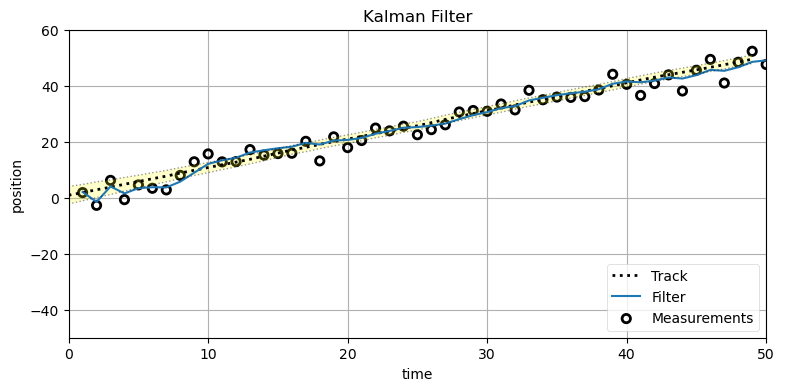

In [27]:
from scipy.linalg import inv

count = 50
track, zs = compute_data(R_var, Q_var, count)
xs, cov = [], []
for z in zs:
    # predict
    x = F @ x
    P = F @ P @ F.T + Q
    
    #update
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = z - H @ x
    x += K @ y
    P = P - K @ H @ P
    
    xs.append(x)
    cov.append(P)

xs, cov = np.array(xs), np.array(cov)
plot_track(xs[:, 0], track, zs, cov, plot_P=False)

### Резюме

Мы изучили уравнения фильтра Калмана.

$$
\begin{aligned}
\text{Predict Step}\\
\mathbf{\bar x} &= \mathbf{F x} + \mathbf{B u} \\
\mathbf{\bar P} &= \mathbf{FP{F}}^\mathsf T + \mathbf Q \\
\\
\text{Update Step}\\
\textbf{S} &= \mathbf{H\bar PH}^\mathsf T + \mathbf R \\
\mathbf K &= \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1} \\
\textbf{y} &= \mathbf z - \mathbf{H \bar x} \\
\mathbf x &=\mathbf{\bar x} +\mathbf{K\textbf{y}} \\
\mathbf P &= (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}
\end{aligned}
$$

Я хочу поделиться формой уравнений, которую вы увидите в литературе. Используется много различных систем обозначений, но это дает вам представление о том, чего ожидать.
 $$
\begin{aligned}
\hat{\mathbf x}_{k\mid k-1} &= \mathbf F_k\hat{\mathbf x}_{k-1\mid k-1} + \mathbf B_k \mathbf u_k  \\
\mathbf P_{k\mid k-1} &=  \mathbf F_k \mathbf P_{k-1\mid k-1} \mathbf F_k^\mathsf T + \mathbf Q_k \\        	
\tilde{\mathbf y}_k &= \mathbf z_k - \mathbf H_k\hat{\mathbf x}_{k\mid k-1}\\
\mathbf{S}_k &= \mathbf H_k \mathbf P_{k\mid k-1} \mathbf H_k^\mathsf T + \mathbf R_k \\
\mathbf K_k &= \mathbf P_{k\mid k-1}\mathbf H_k^\mathsf T \mathbf{S}_k^{-1}\\
\hat{\mathbf x}_{k\mid k} &= \hat{\mathbf x}_{k\mid k-1} + \mathbf K_k\tilde{\mathbf y}_k\\
\mathbf P_{k|k} &= (I - \mathbf K_k \mathbf H_k) \mathbf P_{k|k-1}
\\\end{aligned}
$$

В этой нотации используется байесовская нотация $a\mid b$, что означает $a$ с учетом доказательств $b$. Hat означает оценку. Таким образом, $\hat{\mathbf x}_{k\mid k}$ означает оценку состояния $\mathbf x$ на шаге $k$ (первый k) с учетом доказательств с шага $k$ (второй k). Другими словами, $\hat{\mathbf x}_{k\mid k-1}$ означает оценку состояния $\mathbf x$ на шаге $k$ с учетом оценки с шага $k-1$.
